<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Продажи-в-штуках" data-toc-modified-id="Продажи-в-штуках-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Продажи в штуках</a></span></li><li><span><a href="#Продажи-в-деньгах" data-toc-modified-id="Продажи-в-деньгах-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Продажи в деньгах</a></span></li></ul></li><li><span><a href="#Выбросы-и-корреляции" data-toc-modified-id="Выбросы-и-корреляции-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выбросы и корреляции</a></span><ul class="toc-item"><li><span><a href="#Корреляции-по-товарной-иерархии" data-toc-modified-id="Корреляции-по-товарной-иерархии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Корреляции по товарной иерархии</a></span></li></ul></li><li><span><a href="#Кластеризация" data-toc-modified-id="Кластеризация-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация</a></span><ul class="toc-item"><li><span><a href="#По-группам-магазинов" data-toc-modified-id="По-группам-магазинов-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>По группам магазинов</a></span></li></ul></li></ul></div>

**Задача:**
Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного
производства. Гранулярность ТК-SKU-День. <div>
**Цель:**
Сгенерировать различные признаки и придумать интерпретируемую, описывающую правильные
зависимости (повышение цены вызывает логичное падение спроса), модель прогноза спроса.
Дальше необходимо сделать подневной прогноз спроса на тестовом периоде для каждого товара
и магазина, и команда Ленты оценит его качество в сравнении с свершившимся фактом.
Метрикой качества будет выступать WAPE, посчитанный на уровне товар, магазин, день. Если
есть пропущенные значения и по каким-то товарам не предоставлен прогноз, прогноз считается
равным нулю.

<aside>
🔥 **Работа направляется на проверку 1 октября до 10:00 по мск.**

</aside>

1. Файл в зафиксированном формате с результатом прогноза спроса (sales_submission.csv).
2. Воспроизводимый код на Python
3. Описание решения:
    
    a. Описание обученной модели прогноза спроса
    
    i. Признаки
    ii. интерпретация (shapley values),
    iii. кросс-валидация
    iv. алгоритмы
    
    b. Описание вашего алгоритма оптимизации:
    
    i. методология расчетов
    ii. скорость оптимизации

# Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #импортируем библиотеки для графиков
import seaborn as sns
import warnings #для игнорирования предупреждений об ошибках
warnings.filterwarnings("ignore")

C:\Users\algol\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Описание датасетов и столбцов:<div>
1) sales_df_train.csv –данные по продажам за скользящий год для обучения. <div>
Столбцы:
st_id – захэшированное id магазина;
pr_sku_id – захэшированное id товара;
date – дата;
pr_sales_type_id – флаг наличия промо;
pr_sales_in_units – число проданных товаров всего (промо и без);
pr_promo_sales_in_units – число проданных товаров с промо;
pr_sales_in_rub – продажи в РУБ всего (промо и без);
pr_promo_sales_in_rub – продажи с признаком промо в РУБ; <div>
2) pr_df.csv – данные по товарной иерархии. <div>
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
Столбцы:
pr_group_id – захэшированная группа товара;
pr_cat_id – захэшированная категория товара;
pr_subcat_id – захэшированная подкатегория товара;
pr_sku_id – захэшированное id товара;
pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).<div>
3) st_df.csv – данные по магазинам. <div>
Столбцы:
st_id – захэшированное id магазина;
st_city_id – захэшированное id города;
st_division_code id – захэшированное id дивизиона;
st_type_format_id – id формата магазина;
st_type_loc_id – id тип локации/окружения магазина;
st_type_size_id – id типа размера магазина;
st_is_active – флаг активного магазина на данный момент.<div>
4) sales_submission.csv – пример файла с результатом работы модели прогноза спроса. <div>
Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).
Столбцы:
st_id – захэшированное id магазина;
pr_sku_id – захэшированное id товара;
date – дата (день);
target – спрос в ШТ.

Читаем данные.

In [65]:
df = pd.read_csv("C:/Users/algol/Хакатон_Лента/sales_df_train.csv")
pr_df = pd.read_csv("C:/Users/algol/Хакатон_Лента/pr_df.csv")
st_df = pd.read_csv("C:/Users/algol/Хакатон_Лента/st_df.csv")
sales_submission = pd.read_csv("C:/Users/algol/Хакатон_Лента/sales_submission.csv")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# df = pd.read_csv("/content/drive/MyDrive/2_ML/Хакатон_Лента/sales_df_train.csv")
# pr_df = pd.read_csv("/content/drive/MyDrive/2_ML/Хакатон_Лента/pr_df.csv")
# st_df = pd.read_csv("/content/drive/MyDrive/2_ML/Хакатон_Лента/st_df.csv")
# sales_submission = pd.read_csv("/content/drive/MyDrive/2_ML/Хакатон_Лента/sales_submission.csv")

In [5]:
# изучим состав столбцов для продаж
values = pd.DataFrame()
for col in df.columns:
    values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique()]

values.transpose().sort_values(by=1, ascending=True).rename(
    {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)

,Значения,тип данных,Кол-во уникальных значений
pr_sales_type_id,"[1, 0]",int64,2
pr_sales_in_units,"[5.0, 4.0, 1.0, 0.0, 3.0, 2.0, 63.0, 14.0, 8.0...",float64,392
pr_promo_sales_in_units,"[5.0, 0.0, 4.0, 1.0, 2.0, 8.0, 3.0, 14.0, 26.0...",float64,357
pr_sales_in_rub,"[825.0, 196.0, 78.0, 69.0, 161.0, 123.0, 171.0...",float64,12313
pr_promo_sales_in_rub,"[825.0, 0.0, 69.0, 398.0, 35.0, 199.0, 31.0, 3...",float64,10874
st_id,"[c81e728d9d4c2f636f067f89cc14862c, 42a0e188f50...",object,12
pr_sku_id,"[c7b711619071c92bef604c7ad68380dd, 68f441429e7...",object,1991
date,"[2022-10-20, 2023-01-29, 2023-03-02, 2023-04-0...",object,352


In [6]:
# изучим состав столбцов для магазинов
values = pd.DataFrame()
for col in st_df.columns:
    values[col] = [st_df[col].unique(), st_df[col].dtypes, st_df[col].nunique()]

values.transpose().sort_values(by=1, ascending=True).rename(
    {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)

,Значения,тип данных,Кол-во уникальных значений
st_type_format_id,"[4, 1, 2]",int64,3
st_type_loc_id,"[3, 1, 2]",int64,3
st_type_size_id,"[19, 12, 28, 8, 20, 32]",int64,6
st_is_active,"[0, 1]",int64,2
st_id,"[1aa057313c28fa4a40c5bc084b11d276, bd470ca955d...",object,12
st_city_id,"[1587965fb4d4b5afe8428a4a024feb0d, 955d864a626...",object,7
st_division_code,"[81b4dd343f5880df806d4c5d4a846c64, e26072c92d8...",object,6


In [7]:
# изучим состав товарной иерархии
values = pd.DataFrame()
for col in pr_df.columns:
    values[col] = [pr_df[col].unique(), pr_df[col].dtypes, pr_df[col].nunique()]

values.transpose().sort_values(by=1, ascending=True).rename(
    {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)

,Значения,тип данных,Кол-во уникальных значений
pr_uom_id,"[17, 1]",int64,2
pr_sku_id,"[fd064933250b0bfe4f926b867b0a5ec8, 71c9661741c...",object,2050
pr_group_id,"[c74d97b01eae257e44aa9d5bade97baf, 6512bd43d9c...",object,9
pr_cat_id,"[1bc0249a6412ef49b07fe6f62e6dc8de, c559da2ba96...",object,43
pr_subcat_id,"[ca34f669ae367c87f0e75dcae0f61ee5, e06f5ed7719...",object,170


Имеется 9 групп товаров, 43 категории товаров и 170 подкатегорий товаров.

In [8]:
df['date'].min()

'2022-08-01'

In [9]:
df['date'].max()

'2023-07-18'

Всего 12 магазинов в 7 городах в которых 1991 товар. Представлены данные за 1 год c 1 августа 2022 по 18 июля 2023. Даты в виде строк по дням. Даты нужно будет конвертировать в соответствующий формат.

Имеются 5 типоразмеров магазинов. 2 магазина не активны. 3 географических локации нахождения магазинов.

In [10]:
# датасет куда предсказываем
sales_submission

,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0
...,...,...,...,...
43689,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fd519eb13005448a303df1089505a42b,2023-08-01,0
43690,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fdb89dfd1a27256904eb5a5734252102,2023-08-01,0
43691,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-08-01,0
43692,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe5d18ae6650335830e4c1dbd9e6ddb9,2023-08-01,0


In [11]:
sales_submission['date'].min()

'2023-07-19'

In [12]:
sales_submission['date'].max()

'2023-08-01'

In [13]:
# изучим состав товарной иерархии
values = pd.DataFrame()
for col in sales_submission.columns:
    values[col] = [sales_submission[col].unique(), sales_submission[col].dtypes, sales_submission[col].nunique()]

values.transpose().sort_values(by=1, ascending=True).rename(
    {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)

,Значения,тип данных,Кол-во уникальных значений
target,[0],int64,1
st_id,"[16a5cdae362b8d27a1d8f8c7b78b4330, 1ecfb463472...",object,8
pr_sku_id,"[0045ebdb1069ff4b3dd3efe628c39cd3, 00661699f54...",object,1087
date,"[2023-07-20, 2023-07-21, 2023-07-22, 2023-07-2...",object,14


In [14]:
# данные по товарной иерархии
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [15]:
#количество записей не совпадает с количеством уникальных товаров в основном датафрейме.
# посмотрим на количество уникальных значений в столбце с товарами.
pr_df['pr_sku_id'].nunique()

2050

Просто здесь уникальных товаров больше, чем в основном датафрейме.

In [16]:
#посмотрим пропуски и дубликаты
count_missing = df.isna().sum()
percent_missing = round(df.isna().sum() * 100 / len(df), 2)
count_duplicates = df.duplicated().sum()

missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'num_missing': count_missing,
                                     'percent_missing': percent_missing,
                                     'num_duplicates': count_duplicates})
missing_value_df.sort_values(by="percent_missing", ascending = False)

,column_name,num_missing,percent_missing,num_duplicates
st_id,st_id,0,0.0,0
pr_sku_id,pr_sku_id,0,0.0,0
date,date,0,0.0,0
pr_sales_type_id,pr_sales_type_id,0,0.0,0
pr_sales_in_units,pr_sales_in_units,0,0.0,0
pr_promo_sales_in_units,pr_promo_sales_in_units,0,0.0,0
pr_sales_in_rub,pr_sales_in_rub,0,0.0,0
pr_promo_sales_in_rub,pr_promo_sales_in_rub,0,0.0,0


Пропуски и явные дубликаты отсутствуют.

In [17]:
#переведем дату в формат даты
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


# Исследовательский анализ данных

## Продажи в штуках

Посмотрим на общее количество продаж.

In [18]:
df['pr_sales_in_units'].describe()

count    883015.000000
mean          5.037956
std          13.402984
min         -39.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

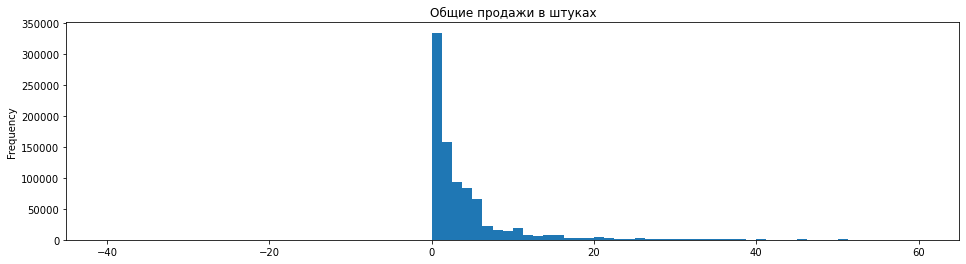

In [19]:
df['pr_sales_in_units'].plot(kind ='hist', title = 'Общие продажи в штуках', bins = 80, range = (-40, 60), figsize=(16,4));

Для общих продаж в штуках имеются отрицательные значения. Распределение отличается от нормального. Ассиметрия значнеий вблизи значения 0.

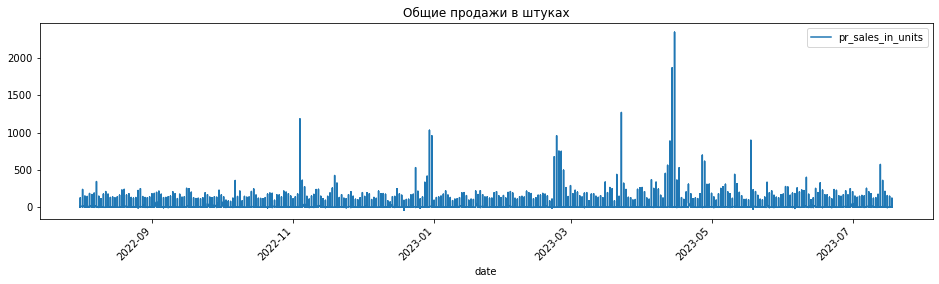

In [20]:
# визуализируем по числу проданных товаров
df.plot(x='date', y = 'pr_sales_in_units', figsize=(16,4), title = 'Общие продажи в штуках')
plt.xticks(rotation=45)
plt.yticks()
plt.show()

Заметно, что в определенные дни имеются пики продаж.

In [21]:
df['pr_promo_sales_in_units'].describe()

count    883015.000000
mean          2.230010
std          11.063288
min         -39.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        2348.000000
Name: pr_promo_sales_in_units, dtype: float64

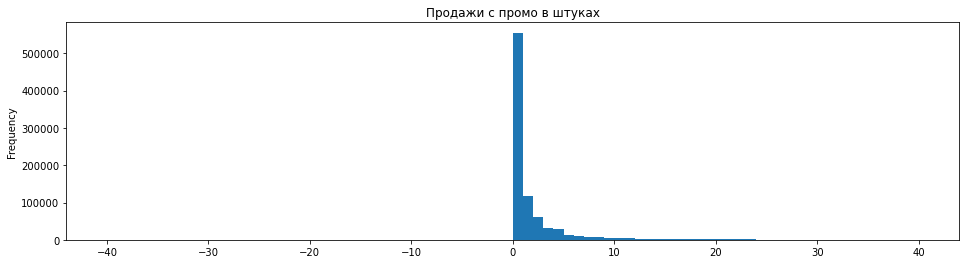

In [22]:
df['pr_promo_sales_in_units'].plot(kind ='hist', title = 'Продажи с промо в штуках', bins = 80, range = (-40, 40), figsize=(16,4));

Видимо 50% дней промо не было. Распределение отличается от нормального. Ассиметрия вблизи значения 0.

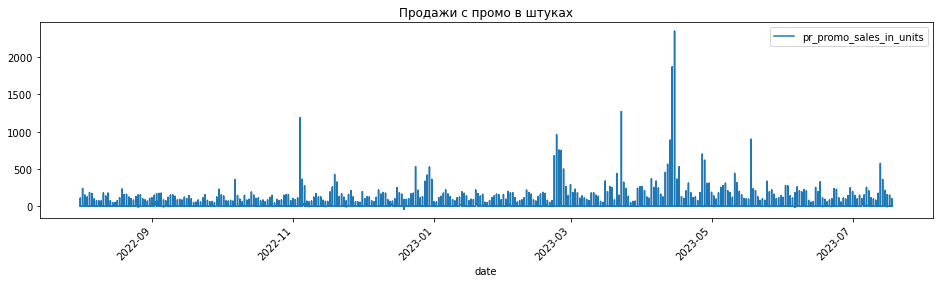

In [23]:
# визуализируем по числу проданных товаров с признаком промо
df.plot(x='date', y = 'pr_promo_sales_in_units', figsize=(16,4), title = 'Продажи с промо в штуках',)
plt.xticks(rotation=45)
plt.yticks()
plt.show()

Также заметны пики продаж в определенные дни. Вместе с тем, заметна разница в динамике по времени между общими продажами и продажами с промо.

## Продажи в деньгах

In [24]:
# Общее количество продаж
df['pr_sales_in_rub'].describe()

count    883015.000000
mean        596.705181
std        1577.366179
min       -3373.000000
25%          98.000000
50%         224.000000
75%         540.000000
max      183265.000000
Name: pr_sales_in_rub, dtype: float64

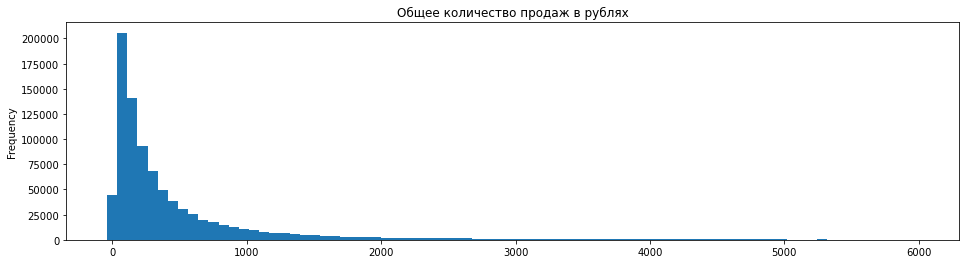

In [25]:
df['pr_sales_in_rub'].plot(kind ='hist', title = 'Общее количество продаж в рублях', bins = 80, range = (-40, 6000), figsize=(16,4));

Имеются отрицательные значения. Распределение отличается от нормального. Ассиметрия вблизи значения 0.

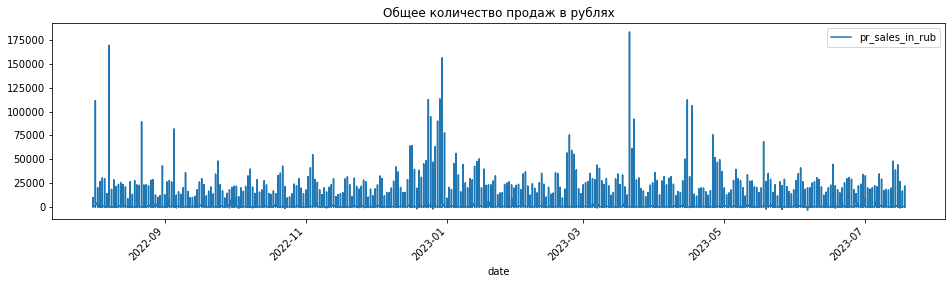

In [26]:
# визуализируем по числу проданных товаров с признаком промо
df.plot(x='date', y = 'pr_sales_in_rub', figsize=(16,4), title = 'Общее количество продаж в рублях')
plt.xticks(rotation=45)
plt.yticks()
#plt.ylim([0, 12000])
plt.show()

In [27]:
# Продажи с промо
df['pr_promo_sales_in_rub'].describe()

count    883015.000000
mean        294.766561
std        1402.764168
min       -3373.000000
25%           0.000000
50%           0.000000
75%         127.000000
max      183265.000000
Name: pr_promo_sales_in_rub, dtype: float64

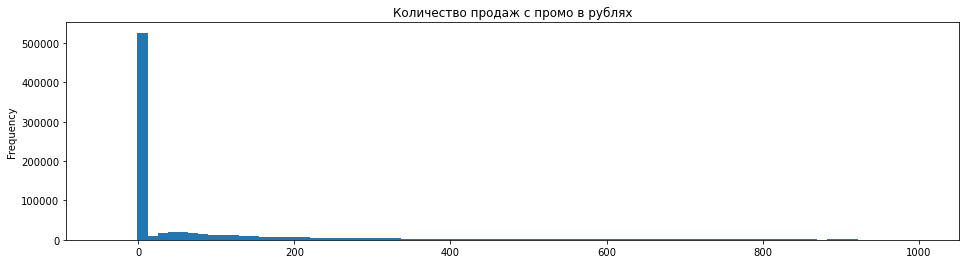

In [28]:
df['pr_promo_sales_in_rub'].plot(kind ='hist', title = 'Количество продаж с промо в рублях', bins = 80, range = (-40, 1000), figsize=(16,4));

Имеются отрицательные продажи. Как и в штуках 50% значений равно нулю.

In [29]:
len(df)

883015

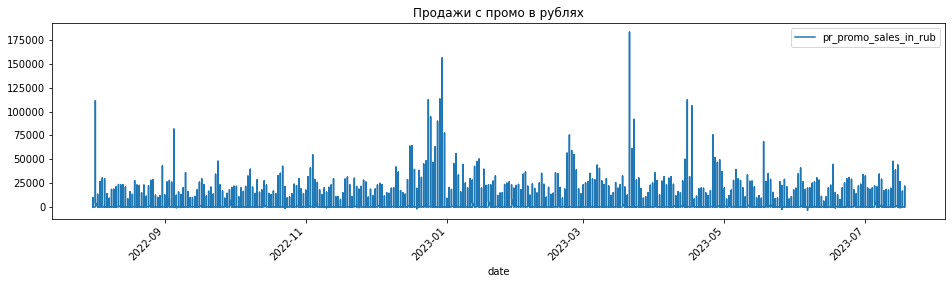

In [30]:
# визуализируем по числу проданных товаров с признаком промо
df.plot(x='date', y = 'pr_promo_sales_in_rub', figsize=(16,4), title = 'Продажи с промо в рублях')
plt.xticks(rotation=45)
plt.yticks()
#plt.ylim([0, 6000])
plt.show()

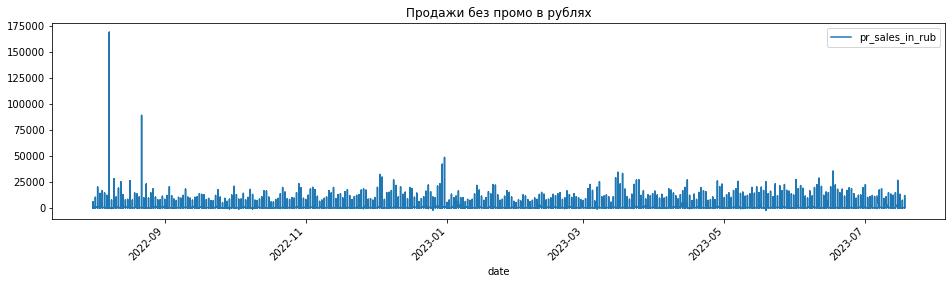

In [31]:
df_no_promo = df.query("pr_sales_type_id==0") # and date < '2022-08-13'")
# визуализируем по числу проданных товаров с признаком промо
df_no_promo.plot(x='date', y = 'pr_sales_in_rub', figsize=(16,4), title = 'Продажи без промо в рублях')
plt.xticks(rotation=45)
plt.yticks()
#plt.ylim([0, 6000])
plt.show()

Совершенно точно имеются определенные дни в которые кратный рост продаж.Вне зависимости от наличия/отсутствия промо.

Промо акции совпадают с праздниками. 

Посмотрим на продажи меньше нуля.

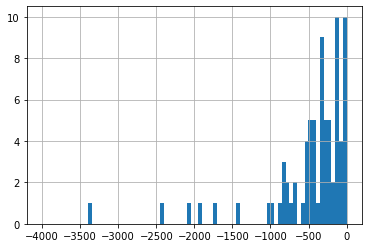

In [32]:
df['pr_sales_in_rub'].hist(bins=80, range = (-4000,-1));

В датасете имеются отрицательные продажи, мы их удаляем, потому что предположительно это возврат. Количество таких данных составляет менее 1%.

**Выводы:**
1. Имеются отрицательные продажи в штуках и в рублях. Количество отрицательных продаж незначительно, предполагаем, что это связано с возвратами и считаем возможным удалить.
2. В определенные дни имеется кратный рост продаж вне зависимости от наличия промо-акций.
3. Цикличность на графиках отметить не удалось, т.к.расстояние между пиками различное.
4. Промо-акции совпадают с праздниками.

# Выбросы и корреляции

In [33]:
st_df[st_df['st_is_active'] == 0]

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
10,62f91ce9b820a491ee78c108636db089,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,32,0


Магазины с флагом ноль не активны, учитывая что у нас стоит задача спрогнозировать по активным магазинам мы удалим из рассмотрения неактивные. Их 2 и они имеют следующие шифры 1aa057313c28fa4a40c5bc084b11d276 и 62f91ce9b820a491ee78c108636db089.

In [34]:
#оставим датафрейм с положительными продажами и активными магазинами
df_positive_sales = df.query('pr_sales_in_rub >=0')
df_positive_sales= df_positive_sales.query('st_id != "1aa057313c28fa4a40c5bc084b11d276"')
df_positive_sales= df_positive_sales.query('st_id != "62f91ce9b820a491ee78c108636db089"')
df_positive_sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [35]:
df_positive_sales[df_positive_sales['pr_sales_in_units'] < 0]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
277226,fa7cdfad1a5aaf8370ebeda47a1ff1c3,4a1167f2c6700c1ab5e2435a2ff300e7,2023-02-16,1,-1.0,-1.0,0.0,0.0


Осталось одно наблюдение с отрицательным значением в штуках. Удалим и его.

In [36]:
df_positive_sales = df_positive_sales.query('pr_sales_in_units >=0')

In [63]:
#также удалим отрицательные продажи для промо
df_positive_sales = df_positive_sales.query('pr_promo_sales_in_units >=0')
df_positive_sales = df_positive_sales.query('pr_promo_sales_in_rub >=0').reset_index(drop= True)
df_positive_sales.shape

(882207, 9)

In [38]:
#посчитаем сколько удаленно в процентах
100-(len(df_positive_sales)/len(df))*100

0.09150467432603193

Процент удаленных данных ничтожно мал, поэтому далее можно работать с очищенным датасетом.

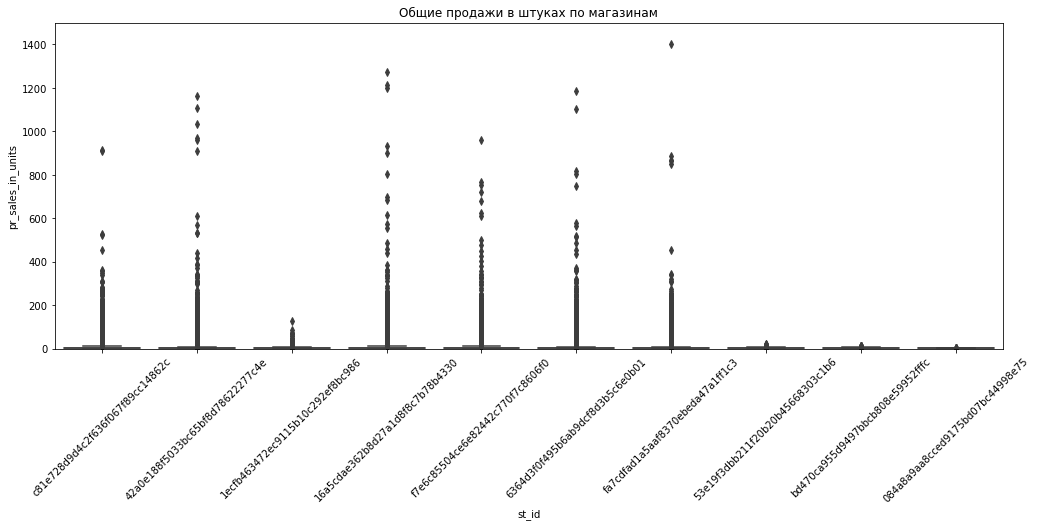

In [39]:
#Посмотрим боксплоты общих продаж в штуках по магазинам
var = 'st_id'
data = pd.concat([df_positive_sales['pr_sales_in_units'], df_positive_sales[var]], axis=1)
f, ax = plt.subplots(figsize=(17, 6))
fig = sns.boxplot(x=var, y="pr_sales_in_units", data=data)
fig.axis(ymin=0, ymax=1500)
plt.xticks(rotation=45)
plt.title('Общие продажи в штуках по магазинам');

In [40]:
# посчитаем медианные значения количества товаров по магазинам
df_positive_sales.groupby('st_id')['pr_sales_in_units'].median()

st_id
084a8a9aa8cced9175bd07bc44998e75    1.0
16a5cdae362b8d27a1d8f8c7b78b4330    2.0
1ecfb463472ec9115b10c292ef8bc986    2.0
42a0e188f5033bc65bf8d78622277c4e    2.0
53e19f3dbb211f20b20b45668303c1b6    2.0
6364d3f0f495b6ab9dcf8d3b5c6e0b01    2.0
bd470ca955d9497bbcb808e59952fffc    1.0
c81e728d9d4c2f636f067f89cc14862c    2.0
f7e6c85504ce6e82442c770f7c8606f0    2.0
fa7cdfad1a5aaf8370ebeda47a1ff1c3    2.0
Name: pr_sales_in_units, dtype: float64

В основном в магазинах берут 1, 2 товара и основная масса не более 10 товаров. Имеются случаи огромных заказов с количеством более 1000 товаров. Можно выделить 2 группы магазинов с огромными заказами и с заказами где самый большой заказ не превышает 120 штук.   

Для выделения в один кластер сделаем список из 4х магазинов, где максимальные заказы не превышают 120 штук.

In [41]:
less_120 = ['fa7cdfad1a5aaf8370ebeda47a1ff1c3', '53e19f3dbb211f20b20b45668303c1b6', '084a8a9aa8cced9175bd07bc44998e75', '42a0e188f5033bc65bf8d78622277c4e']

Повториться ли ситуация с заказами в рублях.

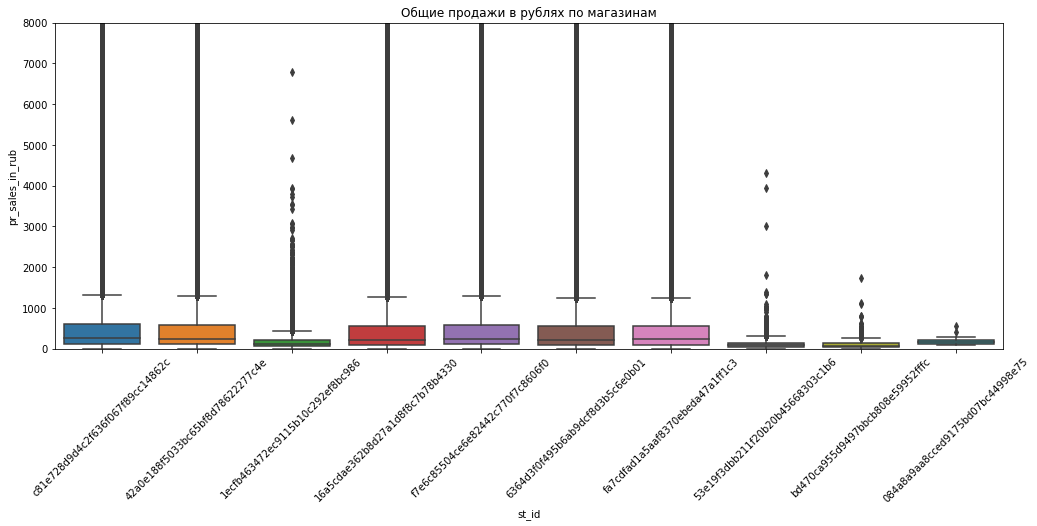

In [42]:
#Посмотрим боксплоты общих продаж в штуках по магазинам
var = 'st_id'
data = pd.concat([df_positive_sales['pr_sales_in_rub'], df_positive_sales[var]], axis=1)
f, ax = plt.subplots(figsize=(17, 6))
fig = sns.boxplot(x=var, y="pr_sales_in_rub", data=data)
fig.axis(ymin=0, ymax=8000)
plt.xticks(rotation=45)
plt.title('Общие продажи в рублях по магазинам');

Заметно, что имеются 2 группы магазинов по уровням максимальных продаж.

In [43]:
#Соотнесем 3 наибольших случая по количетву продаж
df_positive_sales['pr_sales_in_units'].sort_values(ascending=False).head(3)

339377    2348.0
48675     1872.0
646869    1596.0
Name: pr_sales_in_units, dtype: float64

In [44]:
df_positive_sales['pr_sales_in_rub'][339377:339378]

339377    62429.0
Name: pr_sales_in_rub, dtype: float64

In [45]:
df_positive_sales['pr_sales_in_rub'][48675:48676]

48675    50034.0
Name: pr_sales_in_rub, dtype: float64

In [46]:
df_positive_sales['pr_sales_in_rub'][646869:646870]

646869    70790.0
Name: pr_sales_in_rub, dtype: float64

В большом количестве продаются дешевые товары стоимостью 2-5 рублей. Мы не можем сказать выброс это или нет поэтому оставляем.

In [47]:
df_positive_sales.shape

(882207, 8)

## Корреляции по товарной иерархии

In [48]:
#объединим датафрейм с продажами с датафреймом с иерархией
df_corr = df_positive_sales.merge(pr_df, left_on = 'pr_sku_id', right_on = 'pr_sku_id', how = 'left')
df_corr.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1


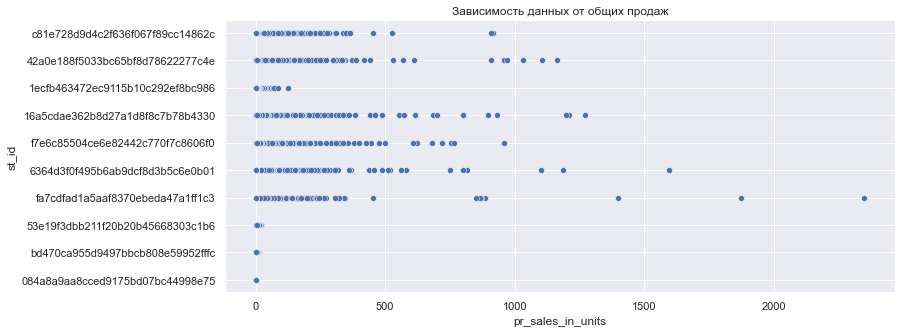

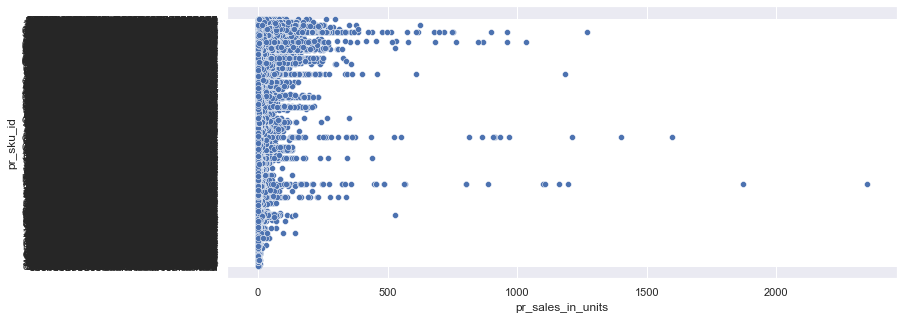

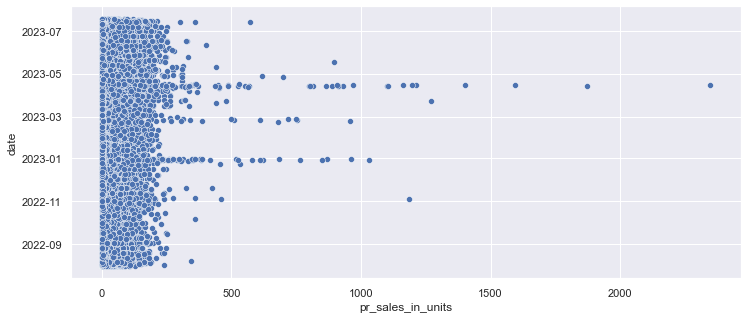

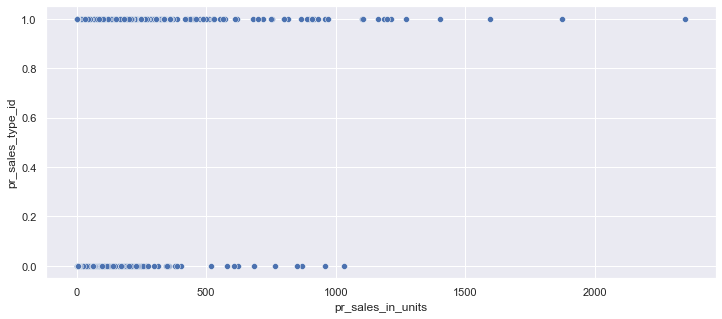

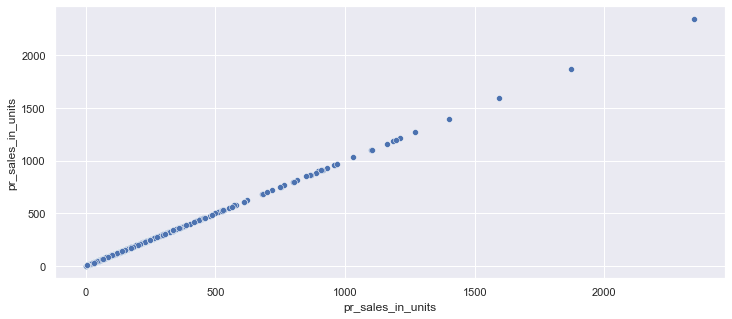

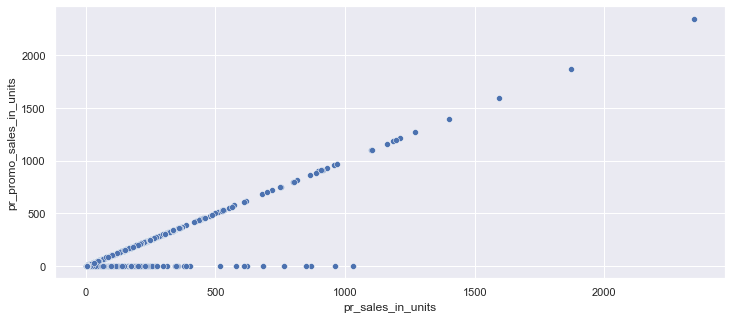

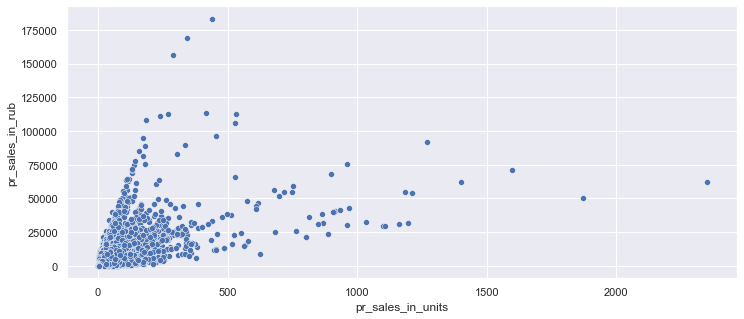

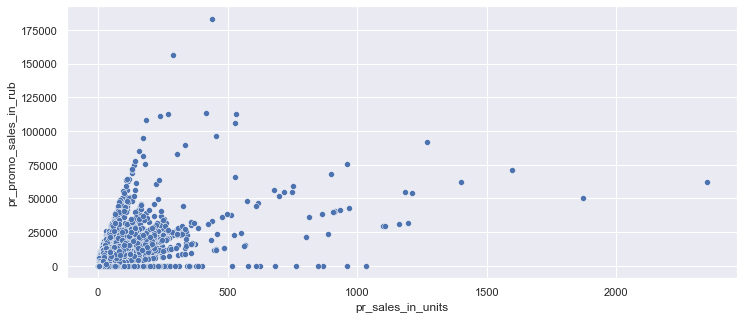

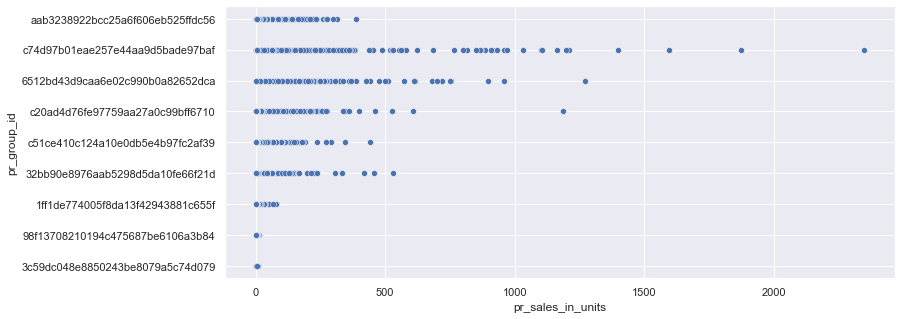

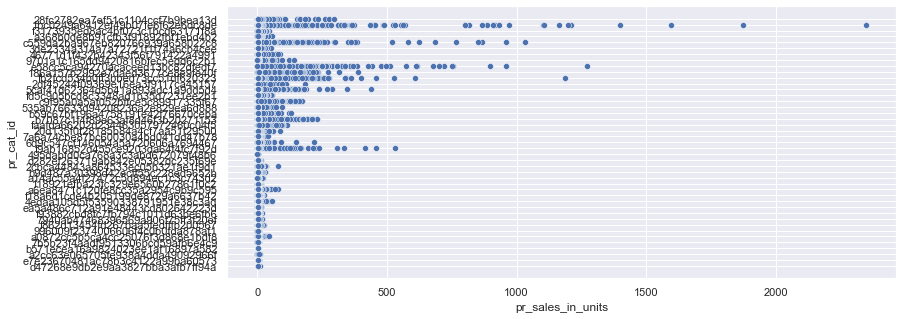

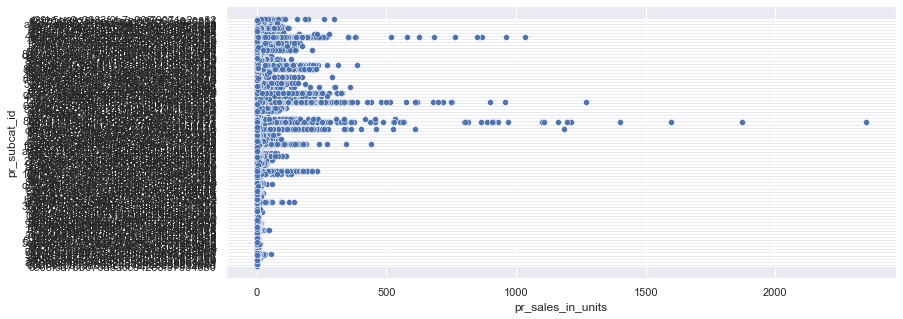

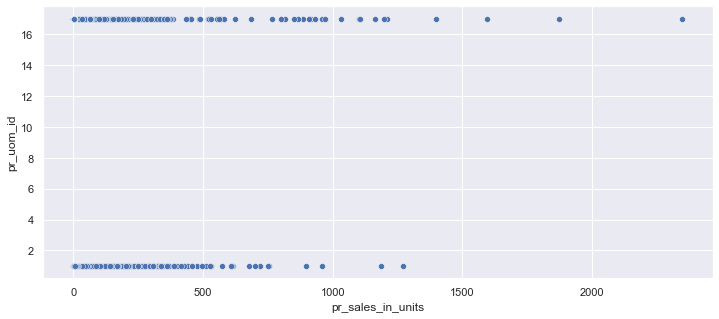

In [49]:
#построим попарные диаграммы рассеяния различных данных в зависимости от общих продаж
sns.set(rc={'figure.figsize':(12,5)})
plt.title('Зависимость данных от общих продаж')
for col in df_corr.columns:
    sns.scatterplot(x = df_corr['pr_sales_in_units'], y = df_corr[col])
    plt.show()

Посмотрим все ли группы товаров растут в праздники по продажам.

In [50]:
df_corr['pr_group_id'].unique()

array(['aab3238922bcc25a6f606eb525ffdc56',
       'c74d97b01eae257e44aa9d5bade97baf',
       '6512bd43d9caa6e02c990b0a82652dca',
       'c20ad4d76fe97759aa27a0c99bff6710',
       'c51ce410c124a10e0db5e4b97fc2af39',
       '32bb90e8976aab5298d5da10fe66f21d',
       '1ff1de774005f8da13f42943881c655f',
       '98f13708210194c475687be6106a3b84',
       '3c59dc048e8850243be8079a5c74d079'], dtype=object)

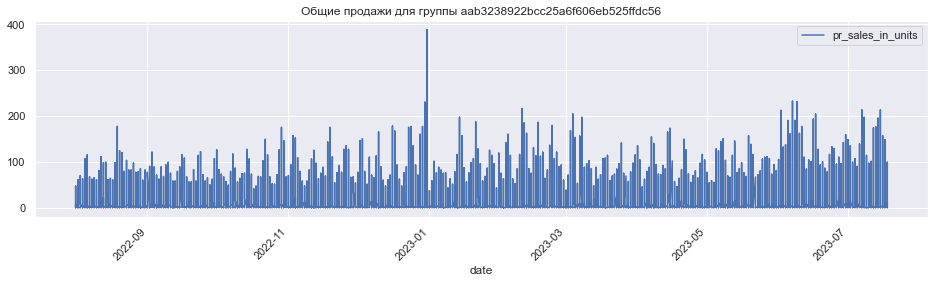

In [51]:
# визуализируем по числу проданных товаров для группы aab3238922bcc25a6f606eb525ffdc56
df_corr.query('pr_group_id == "aab3238922bcc25a6f606eb525ffdc56"').plot(x='date', y = 'pr_sales_in_units',\
                                    figsize=(16,4), title = 'Общие продажи для группы aab3238922bcc25a6f606eb525ffdc56')
plt.xticks(rotation=45)
plt.yticks()
plt.show()

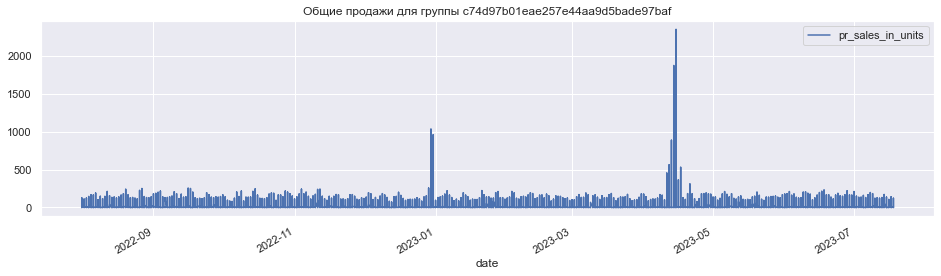

In [52]:
df_corr.query('pr_group_id == "c74d97b01eae257e44aa9d5bade97baf"').plot(x='date', y = 'pr_sales_in_units', \
                                    figsize=(16,4), title = 'Общие продажи для группы c74d97b01eae257e44aa9d5bade97baf');

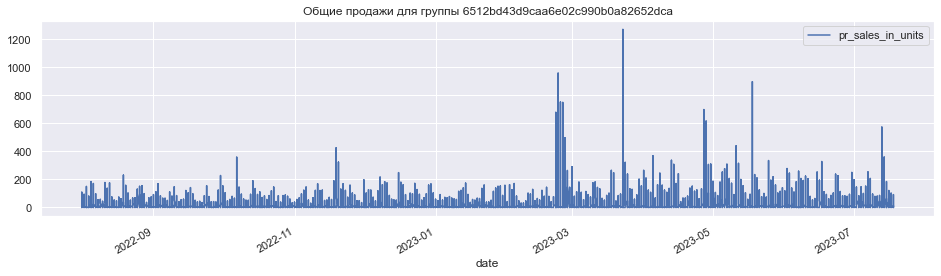

In [53]:
df_corr.query('pr_group_id == "6512bd43d9caa6e02c990b0a82652dca"').plot(x='date', y = 'pr_sales_in_units',\
                                    figsize=(16,4), title = 'Общие продажи для группы 6512bd43d9caa6e02c990b0a82652dca');


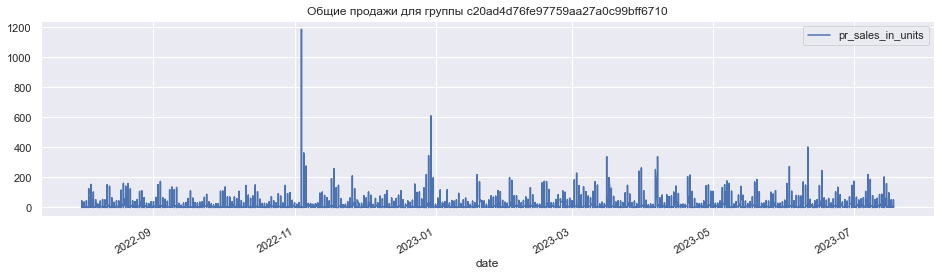

In [54]:
df_corr.query('pr_group_id == "c20ad4d76fe97759aa27a0c99bff6710"').plot(x='date', y = 'pr_sales_in_units',\
                            figsize=(16,4), title = 'Общие продажи для группы c20ad4d76fe97759aa27a0c99bff6710');

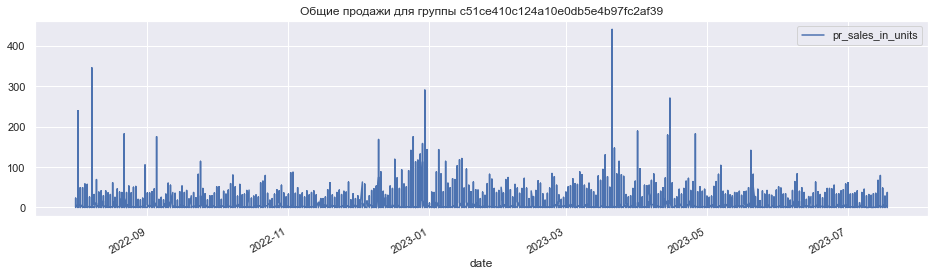

In [55]:
df_corr.query('pr_group_id == "c51ce410c124a10e0db5e4b97fc2af39"').plot(x='date', y = 'pr_sales_in_units',\
                            figsize=(16,4), title = 'Общие продажи для группы c51ce410c124a10e0db5e4b97fc2af39');

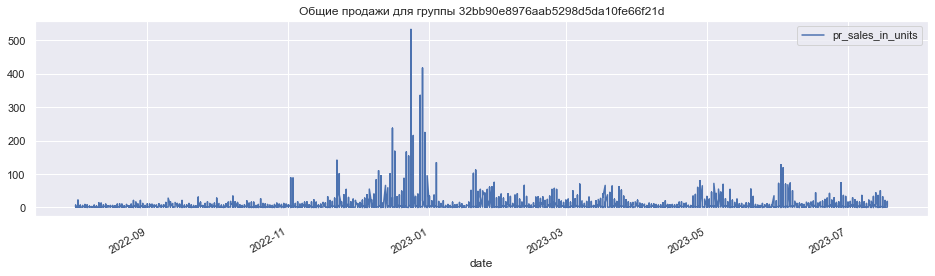

In [56]:
df_corr.query('pr_group_id == "32bb90e8976aab5298d5da10fe66f21d"').plot(x='date', y = 'pr_sales_in_units',\
                            figsize=(16,4), title = 'Общие продажи для группы 32bb90e8976aab5298d5da10fe66f21d');

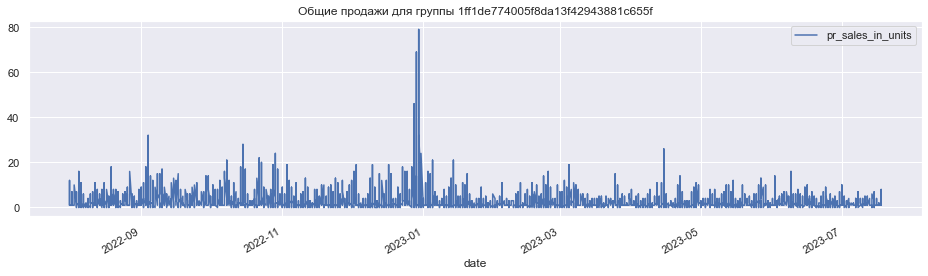

In [57]:
df_corr.query('pr_group_id == "1ff1de774005f8da13f42943881c655f"').plot(x='date', y = 'pr_sales_in_units',\
                            figsize=(16,4), title = 'Общие продажи для группы 1ff1de774005f8da13f42943881c655f');

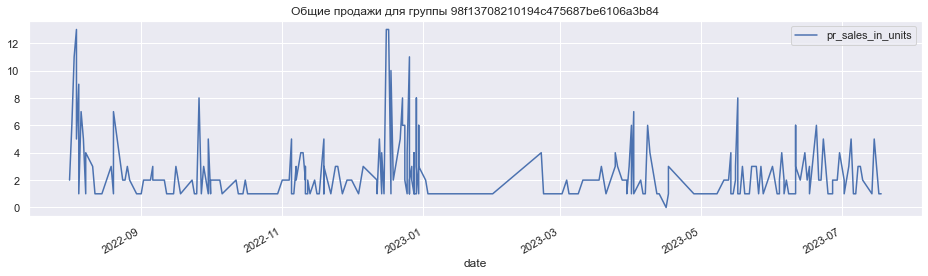

In [58]:
df_corr.query('pr_group_id == "98f13708210194c475687be6106a3b84"').plot(x='date', y = 'pr_sales_in_units',\
                            figsize=(16,4), title = 'Общие продажи для группы 98f13708210194c475687be6106a3b84');

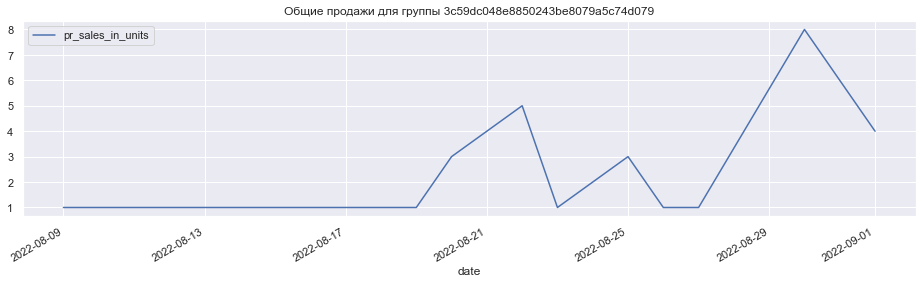

In [59]:
df_corr.query('pr_group_id == "3c59dc048e8850243be8079a5c74d079"').plot(x='date', y = 'pr_sales_in_units',\
                            figsize=(16,4), title = 'Общие продажи для группы 3c59dc048e8850243be8079a5c74d079');

In [60]:
df_corr.query('pr_group_id == "3c59dc048e8850243be8079a5c74d079"').describe()

,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_uom_id
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.0
mean,0.090909,2.636364,0.090909,151.000000,4.909091,1.0
std,0.301511,2.292280,0.301511,125.996032,16.281613,0.0
min,0.000000,1.000000,0.000000,54.000000,0.000000,1.0
25%,0.000000,1.000000,0.000000,69.000000,0.000000,1.0
50%,0.000000,1.000000,0.000000,74.000000,0.000000,1.0
75%,0.000000,3.500000,0.000000,193.500000,0.000000,1.0
max,1.000000,8.000000,1.000000,457.000000,54.000000,1.0


**Выводы:** <div>
1. Количество продаж различается по группам товаров. <div>
2. Таже заметноразличие по категория и субкатегориям товаров.<div>
3. Группы товаров 98f13708210194c475687be6106a3b84 и 3c59dc048e8850243be8079a5c74d079 имеют малые продажи поэтому считаю возможным их выделить в отдельный кластер. 

# Кластеризация

## По группам магазинов

Для использования одних данных удаляю те же данные что и Мария.

In [66]:
df = df[~df['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
df = df[((df['pr_sales_in_units'] != 0) & (df['pr_sales_in_rub'] != 0)) | ((df['pr_sales_in_units'] == 0) & (df['pr_sales_in_rub'] == 0))]
df = df[(df['pr_sales_in_rub'] >= 0) & (df['pr_sales_in_units'] >= 0) & (df['pr_promo_sales_in_rub'] >= 0) & (df['pr_promo_sales_in_units'] >= 0)]
df.shape

(815334, 8)

In [70]:
#создаем столбец пара товар-магазин
df['store_item'] = df['st_id'].str.cat(df['pr_sku_id'], sep='-')
df.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,store_item
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,c81e728d9d4c2f636f067f89cc14862c-c7b711619071c...
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,42a0e188f5033bc65bf8d78622277c4e-68f441429e73d...
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,1ecfb463472ec9115b10c292ef8bc986-22988026fe85f...
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,16a5cdae362b8d27a1d8f8c7b78b4330-e6fc24ca84633...
5,42a0e188f5033bc65bf8d78622277c4e,3474f0e025c7deb7e127a35763bc5512,2022-11-03,0,3.0,0.0,123.0,0.0,42a0e188f5033bc65bf8d78622277c4e-3474f0e025c7d...


In [76]:
#создаем датафрейм с группой магазинов с максимальным количеством менее 120
df_less_120 = df.query('st_id in @less_120')

array(['42a0e188f5033bc65bf8d78622277c4e',
       'fa7cdfad1a5aaf8370ebeda47a1ff1c3',
       '53e19f3dbb211f20b20b45668303c1b6',
       '084a8a9aa8cced9175bd07bc44998e75'], dtype=object)

In [78]:
#создаем датафрейм с группой магазинов с максимальным количеством более 120
df_more_120 = df.query('st_id not in @less_120')
df_more_120['st_id'].unique()

array(['c81e728d9d4c2f636f067f89cc14862c',
       '1ecfb463472ec9115b10c292ef8bc986',
       '16a5cdae362b8d27a1d8f8c7b78b4330',
       'f7e6c85504ce6e82442c770f7c8606f0',
       '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
       'bd470ca955d9497bbcb808e59952fffc'], dtype=object)

In [79]:
df_less_120.shape

(238376, 9)

In [80]:
df_more_120.shape

(576958, 9)

In [82]:
df_less_120.to_csv(r'C:/Users/algol/Хакатон_Лента/df_less_120.csv', index= False) 

In [71]:
#группируем по  паре товар магазин
oneline = df.groupby(['store_item', 'date'])[['pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline.head()

pr_sales_type_id  \
store_item                                         date                           
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-04-07                 1   
                                                   2023-04-11                 1   
                                                   2023-04-12                 1   
                                                   2023-04-29                 0   
                                                   2023-05-24                 0   

                                                               pr_sales_in_units  \
store_item                                         date                            
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-04-07                1.0   
                                                   2023-04-11                1.0   
                                                   2023-04-12                1.0   
                                                   2023-04-29                1.0   
                                                   2023-05-24                1.0   

                                                               pr_sales_in_rub  \
store_item                                         date                          
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-04-07             81.0   
                                                   2023-04-11             81.0   
                                                   2023-04-12             81.0   
                                                   2023-04-29            146.0   
                                                   2023-05-24            146.0   

                                                               pr_promo_sales_in_units  \
store_item                                         date                                  
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-04-07                      1.0   
                                                   2023-04-11                      1.0   
                                                   2023-04-12                      1.0   
                                                   2023-04-29                      0.0   
                                                   2023-05-24                      0.0   

                                                               pr_promo_sales_in_rub  
store_item                                         date                               
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-04-07                   81.0  
                                                   2023-04-11                   81.0  
                                                   2023-04-12                   81.0  
                                                   2023-04-29                    0.0  
                                                   2023-05-24                    0.0

In [ ]:
# создадим датасеты с разбивкой по кластерам
df_less_120 = oneline[oneline['labels']==0]
df_1 = df[df['labels']==1]